In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [3]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

In [4]:
train = train[~((train['type']=='PM2.5')&(train['门头沟']>2000))]

In [5]:
def preprocess(df):
    #convert date and hour columns into a Datetime index
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #remove AQI and all pollutants with suffix '_24h'
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [6]:
train = preprocess(train)
test = preprocess(test)

In [7]:
def process_one_location(df, location, take_log=True, take_diff=True, n_lag=3):
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

    subset_augmented = subset.asfreq('h')
#     subset_augmented = subset_augmented.interpolate(method = 'linear')

#     subset_augmented = subset_augmented.dropna()
    
#     if take_log:
#         subset_augmented = subset_augmented.apply(lambda x: np.log(x))
    if take_log:
        subset_augmented['PM2.5'] = subset_augmented['PM2.5'].map(lambda x: np.log(x))
        
    subset_augmented = feature_engineering(subset_augmented,n_lag,take_diff)
    
#     subset_augmented =  subset_augmented.dropna()
    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    
    if take_diff:
        subset_augmented['target'] = subset_augmented['PM2.5_diff']
        subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    else:
        subset_augmented['target'] = subset_augmented['PM2.5']
        subset_augmented = subset_augmented.drop(columns=['PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag, take_diff=True):
    if take_diff:
        subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
        subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
        subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(24)
#         subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
        subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
#         subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(1)
        subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
#         subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(1)
        subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
#         subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(1)
    
    subset_augmented = create_lag(n_lag,subset_augmented,take_diff)
    
    subset_augmented = calculate_rolling_stat(subset_augmented,take_diff)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res,take_diff=True):
    if take_diff:
        col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    else:
        col = ['PM2.5','PM10','SO2','CO','NO2','O3']
    for p in col:
        res[f'{p}_daily_mean'] = res[p].rolling(24,min_periods=1).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24,min_periods=1).median()
        res[f'{p}_daily_std'] = res[p].rolling(24,min_periods=1).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7,min_periods=1).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7,min_periods=1).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7,min_periods=1).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30,min_periods=1).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30,min_periods=1).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30,min_periods=1).std()
    return res

In [8]:
IS_TAKING_LOG=False
IS_TAKING_DIFF=True

In [9]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    alldata = pd.concat([alldata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTarget = pd.concat([allTarget,true_y])

In [10]:
#In order to calcualte rolling window statistics, we append the last month data from training dataset to our test dataset.
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l,take_log=IS_TAKING_LOG, take_diff=IS_TAKING_DIFF)
    allTestdata = pd.concat([allTestdata,subset])
    true_y['PM2.5_y'] = true_y['PM2.5'].shift(1) 
    allTestTarget = pd.concat([allTestTarget,true_y])

<AxesSubplot:xlabel='None-location', ylabel='None-location'>

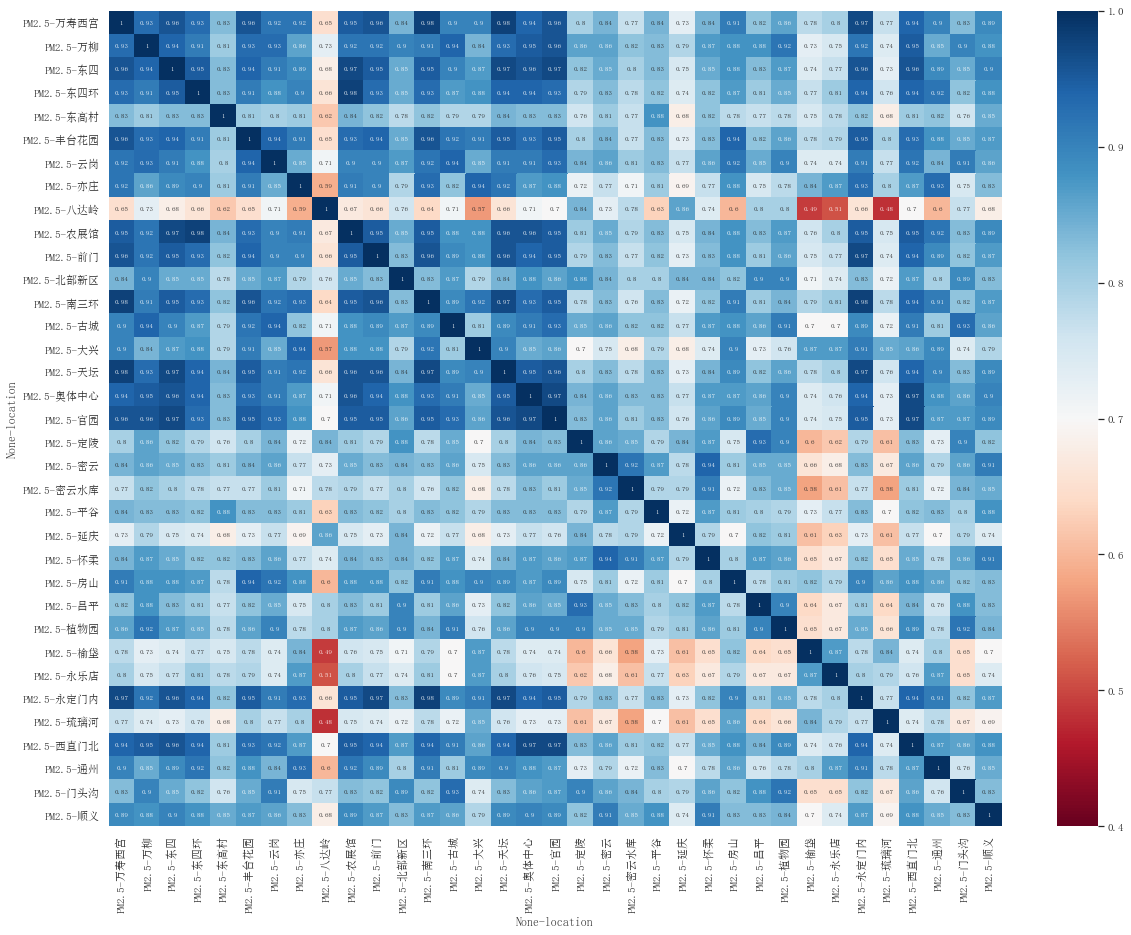

In [13]:
corr_data = allTarget[["PM2.5","location"]].pivot(columns='location')
corr = allTarget[["PM2.5","location"]].pivot(columns='location').corr()
plt.figure(figsize=(20,15))
sns.set(font="SimSun")
sns.heatmap(round(corr,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1)

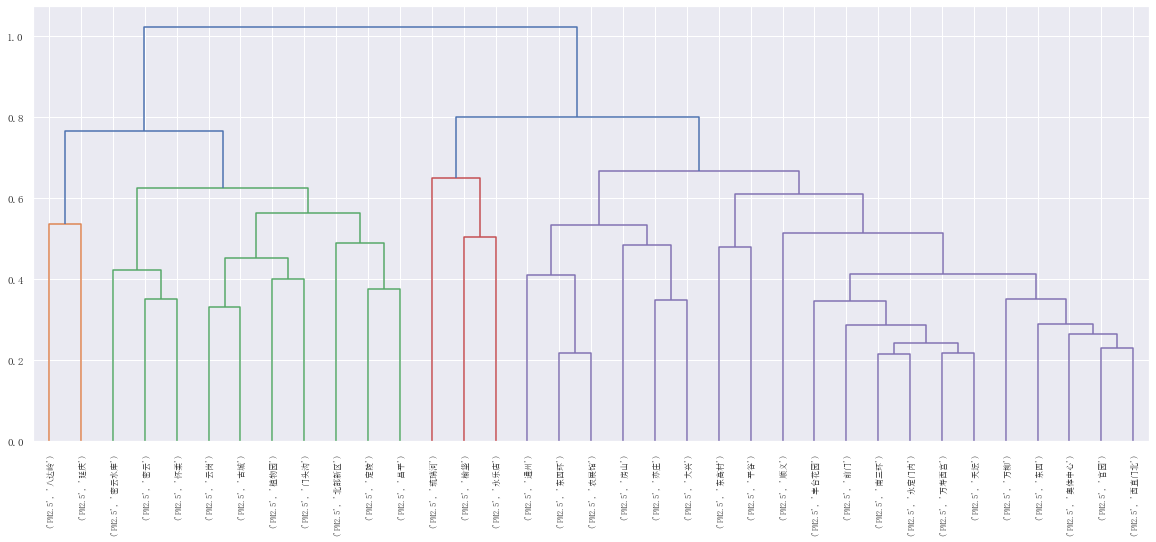

In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
plt.figure(figsize=(20,8))
sns.set(font="SimSun",font_scale=1)
dissimilarity = np.sqrt(2*(1 - corr))
Z = linkage(squareform(dissimilarity), 'complete')

dendrogram(Z, labels=corr_data.columns, orientation='top', 
           leaf_rotation=90);

In [15]:
labels = fcluster(Z, t=5, criterion='maxclust')

labels_order = np.argsort(labels)

for idx, i in enumerate(corr_data.columns[labels_order]):
    if idx == 0:
        clustered = pd.DataFrame(corr_data[i])
    else:
        df_to_append = pd.DataFrame(corr_data[i])
        clustered = pd.concat([clustered, df_to_append], axis=1)

plt.figure(figsize=(15,10))
sns.set(font="SimSun",font_scale=1)
correlations = clustered.corr()
sns.heatmap(round(correlations,2), cmap='RdBu', annot=True, 
            annot_kws={"size": 7}, vmin=0.4, vmax=1);

In [18]:
label_map = {c[1]:labels[i] for i,c in enumerate(corr_data.columns)}
def get_cluster_stats(labels,data):
    data = data.copy(deep=True)
    data['cluster'] = data['location'].map(lambda x: labels[x])
#     c.groupby('b').agg({'a': lambda x: x.mean(skipna=False)})
    tmp = data.groupby([data.index,'cluster'],as_index=False).mean()
    tmp = tmp.set_index(data.groupby([data.index,'cluster']).mean().index.get_level_values(0))
    newdf = pd.DataFrame()
    for c in set(tmp.cluster):
        cluster = tmp[tmp['cluster']==c]
        cluster.columns = [f'{col}_c{c}' for col in tmp.columns]
        newdf = pd.concat([newdf, cluster],axis=1)
    newdf = newdf[[col for col in newdf.columns if 'PM' in col]]
    newdf = pd.merge(newdf,data,left_index=True,right_index=True)
    newdf.drop(columns=['cluster'],inplace=True)
    del tmp
    gc.collect()
    return newdf

In [19]:
alldata = get_cluster_stats(label_map,alldata)
allTestdata = get_cluster_stats(label_map,allTestdata)

In [21]:
if IS_TAKING_DIFF:
    alldata = alldata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    alldata = alldata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

alldata = alldata[alldata.index>'2014-04-03']   #starting from April 3rd for complete data
allTarget = allTarget[allTarget.index>'2014-04-03']   #starting from April 3rd for complete data

In [22]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 841128 entries, 2014-04-03 01:00:00 to 2016-12-29 09:00:00
Columns: 191 entries, PM2.5_diff_lag_1_c1 to target
dtypes: float64(190), object(1)
memory usage: 1.2+ GB


In [24]:
def filter_na(data,true_y,locations):
    res = pd.DataFrame()
    res_test = pd.DataFrame()
    for l in locations:
        subset = data[data['location']==l]
        testing_y = true_y[true_y['location']==l]
        train_notna_index = subset['target'].notna()
        subset = subset[train_notna_index]
        testing_y = testing_y[train_notna_index]
        
        res = pd.concat([res,subset])
        res_test = pd.concat([res_test,testing_y])
    return res, res_test

In [25]:
alldata_noNA, allTarget_noNA = filter_na(alldata,allTarget,train.columns[1:])

In [26]:
if IS_TAKING_DIFF:
    allTestdata = allTestdata.drop(columns=['PM10_diff_lag_1','PM10_diff_lag_2','PM10_diff_lag_3'])
else:
    allTestdata = allTestdata.drop(columns=['PM10_lag_1','PM10_lag_2','PM10_lag_3'])

allTestdata = allTestdata[allTestdata.index>='2017-01-01']
allTestTarget = allTestTarget[allTestTarget.index>='2017-01-01']

In [27]:
allTestdata_noNA, allTestTarget_noNA = filter_na(allTestdata,allTestTarget,train.columns[1:])

,PM2.5_diff_lag_1_c1,PM10_diff_lag_1_c1,PM2.5_diff_lag_2_c1,PM10_diff_lag_2_c1,PM2.5_diff_lag_3_c1,PM10_diff_lag_3_c1,PM2.5_diff_daily_mean_c1,PM2.5_diff_daily_median_c1,PM2.5_diff_daily_std_c1,PM2.5_diff_weekly_mean_c1,...,O3_diff_daily_median,O3_diff_daily_std,O3_diff_weekly_mean,O3_diff_weekly_median,O3_diff_weekly_std,O3_diff_monthly_mean,O3_diff_monthly_median,O3_diff_monthly_std,location,target
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-8.500000,-8.50,NaN,-2.106827,...,NaN,NaN,8.805970,9.0,20.575242,1.386207,0.0,23.496058,东四,1.0
2017-01-02 00:00:00,-8.5,19.0,NaN,NaN,NaN,NaN,-29.250000,-29.25,30.052038,-2.773896,...,NaN,NaN,8.939394,10.5,20.703681,1.388601,0.0,23.516304,东四,-12.0
2017-01-02 01:00:00,-50.0,NaN,-8.5,19.0,NaN,NaN,-22.666667,-20.00,27.844856,-2.498635,...,NaN,NaN,8.939394,10.5,20.703681,1.391003,0.0,23.536602,东四,19.0
2017-01-02 02:00:00,-9.5,-2.0,-50.0,NaN,-8.5,19.0,-12.250000,-8.75,30.837176,-1.625863,...,NaN,NaN,8.939394,10.5,20.703681,1.393414,0.0,23.556953,东四,-10.0
2017-01-02 03:00:00,19.0,4.0,-9.5,-2.0,-50.0,NaN,-11.600000,-9.50,28.064819,-1.130442,...,NaN,NaN,8.939394,10.5,20.703681,1.395833,0.0,23.577356,东四,-62.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-29 19:00:00,-16.0,-16.0,1.0,-29.0,-9.0,18.0,-0.375000,0.00,6.462626,-0.616800,...,-4.0,19.572764,-4.407767,0.0,28.857811,-0.850000,0.0,35.537815,东四环,23.0
2017-04-29 20:00:00,-2.5,5.0,-16.0,-16.0,1.0,-29.0,0.291667,1.00,7.275485,-0.497293,...,-4.0,19.572764,-4.192308,0.0,28.801320,-0.748214,0.0,35.509970,东四环,-15.0
2017-04-29 21:00:00,15.0,-12.5,-2.5,5.0,-16.0,-16.0,0.041667,0.25,7.719042,-0.514032,...,-4.0,19.384914,-3.971429,0.0,28.751741,-0.612500,0.0,35.439760,东四环,12.0


In [ ]:
#rearrange allTestTarget after clustering
# allTestTarget['date'] = allTestTarget.index
# allTestTarget = pd.merge(allTestdata,allTestTarget,left_on=[allTestdata.index,'location'],right_on=[allTestTarget.index,'location'])[["PM2.5","PM2.5_y","location","date"]]
# allTestTarget = allTestTarget.set_index(allTestTarget.date)
# allTestTarget = allTestTarget.drop(columns='date')

In [34]:
alldata_noNA['location'] = alldata_noNA['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noNA['location'].cat.categories ) )
alldata_noNA['location'] = alldata_noNA['location'].cat.codes
allTestdata_noNA['location'] = allTestdata_noNA['location'].astype('category')
allTestdata_noNA['location'] = allTestdata_noNA['location'].cat.codes

In [35]:
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [36]:
import lightgbm as lgb
seed0=617
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.1,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }

In [37]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)

    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits
        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [38]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noNA,allTestdata_noNA,alldata_noNA['location'],lgb_params, n_splits)

Fold: 1
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 12.7718	valid_1's rmse: 14.7133
Early stopping, best iteration is:
[566]	training's rmse: 12.5582	valid_1's rmse: 14.6896
val rmse score is 14.68955744580318
Fold: 2
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 11.8077	valid_1's rmse: 19.3107
Early stopping, best iteration is:
[510]	training's rmse: 11.7746	valid_1's rmse: 19.2955
val rmse score is 19.295475133723002
Fold: 3
Training until validation scores don't improve for 50 rounds
[500]	training's rmse: 13.1141	valid_1's rmse: 12.5167
Early stopping, best iteration is:
[545]	training's rmse: 12.961	valid_1's rmse: 12.4968
val rmse score is 12.496843393823129
Fold: 4
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[406]	training's rmse: 12.2552	valid_1's rmse: 19.2981
val rmse score is 19.298110470735583
Fold: 5
Training until validation scores don't improv

In [39]:
def process_prediction(predicted, true_y, take_log=True, take_diff=True):
    true_y['predicted'] = predicted
    if take_diff:
        true_y['prediction'] = true_y['predicted'] + true_y['PM2.5_y']
    else:
        true_y['prediction'] = true_y['predicted']
        
    true_y['prediction'] = true_y['prediction'].map(lambda x: max(x,0)) # floor at 0
    true_y['prediction'] = true_y['prediction'].map(lambda x: min(x,1000)) # cap at 1000
    
    if take_log:
        true_y['prediction']=true_y['prediction'].map(lambda x: np.exp(x))
        true_y['PM2.5_y']=true_y['PM2.5_y'].map(lambda x: np.exp(x))
        true_y['PM2.5']=true_y['PM2.5'].map(lambda x: np.exp(x))

    true_y.dropna(inplace=True)

In [40]:
process_prediction(predicted,allTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)
process_prediction(test_predictions,allTestTarget_noNA,take_log=IS_TAKING_LOG,take_diff=IS_TAKING_DIFF)

In [41]:
print(f'In sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTarget_noNA["prediction"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for LightGBM method is {np.sqrt(mean_squared_error(allTestTarget_noNA["prediction"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for LightGBM method is 16.09444725743535
Out of sample RMSE for LightGBM method is 18.504286963826132


In [42]:
print(f'In sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTarget_noNA["PM2.5_y"],allTarget_noNA["PM2.5"]))}')
print(f'Out of sample RMSE for Naive method is {np.sqrt(mean_squared_error(allTestTarget_noNA["PM2.5_y"],allTestTarget_noNA["PM2.5"]))}')

In sample RMSE for Naive method is 19.967505740638842
Out of sample RMSE for Naive method is 21.897577293680712


In [43]:
print('Out of sample RMSE for each location is')
display(allTestTarget_noNA.groupby(allTestTarget_noNA.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5))

Out of sample RMSE for each location is


location
万寿西宫    22.201232
万柳      15.118388
东四      17.786126
东四环     16.348936
东高村     19.159717
丰台花园    15.950179
云岗      18.692649
亦庄      15.441316
八达岭     11.929412
农展馆     16.505751
前门      20.307675
北部新区    17.560630
南三环     23.125196
古城      19.866610
大兴      17.004914
天坛      15.777468
奥体中心    15.978027
官园      15.933851
定陵      14.115902
密云      14.581867
密云水库    12.332754
平谷      21.653531
延庆      17.571735
怀柔      16.868248
房山      18.608041
昌平      16.874822
植物园     15.196767
榆垡      28.149158
永乐店     20.534050
永定门内    22.453541
琉璃河     24.683424
西直门北    21.335029
通州      19.350528
门头沟     21.151242
顺义      16.544711
dtype: float64

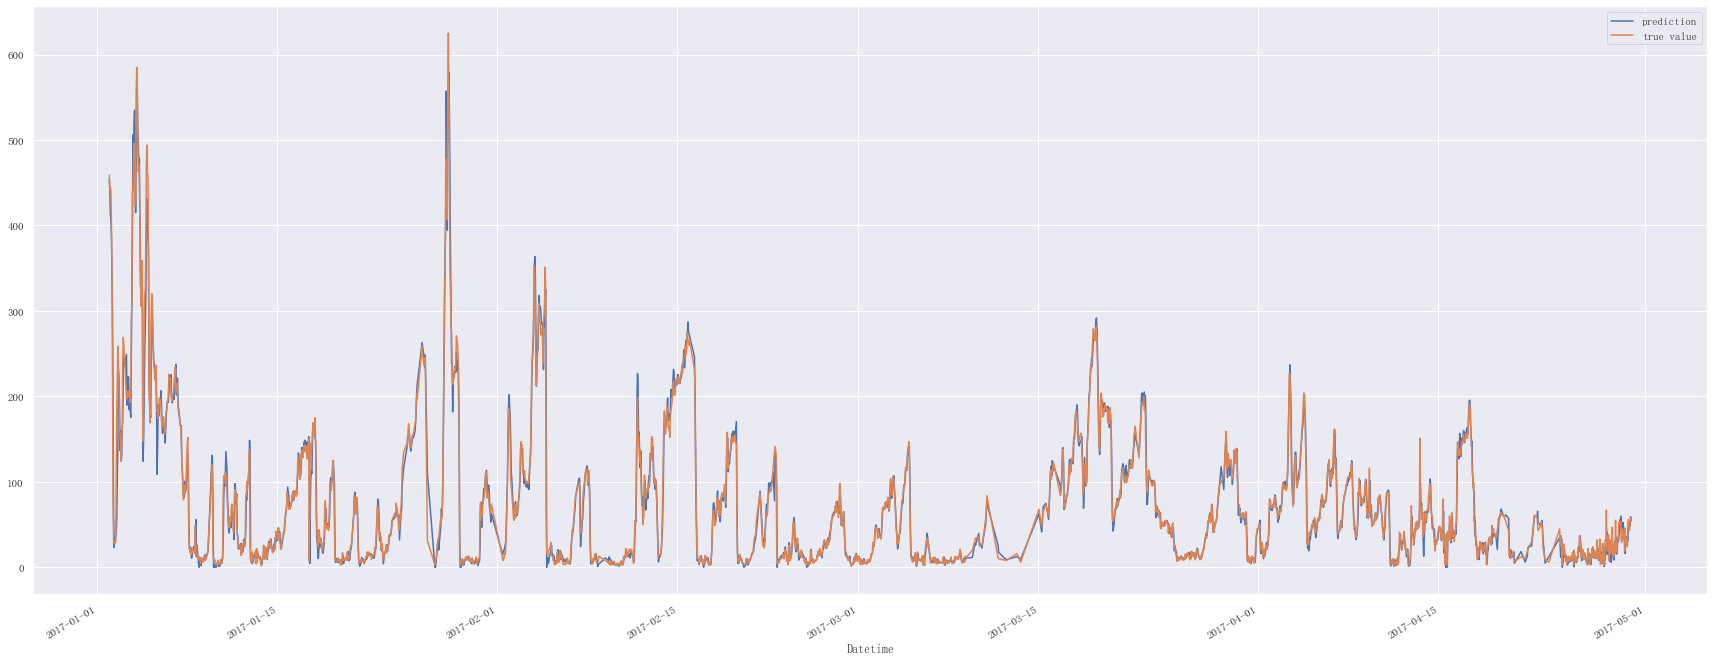

In [47]:
plt.figure(figsize=(30, 12))
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['prediction'].plot(label='prediction')
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']['PM2.5'].plot(label='true value')
plt.legend()
plt.show()

In [49]:
allTestTarget_noNA[allTestTarget_noNA['location']=='万柳']

,PM2.5,location,PM2.5_y,predicted,prediction
Datetime,,,,,
2017-01-01 23:00:00,459.0,万柳,468.0,-13.846027,454.153973
2017-01-02 00:00:00,441.0,万柳,459.0,-17.301278,441.698722
2017-01-02 01:00:00,445.0,万柳,441.0,-27.803474,413.196526
2017-01-02 02:00:00,440.0,万柳,445.0,-39.407572,405.592428
2017-01-02 03:00:00,403.0,万柳,440.0,-51.524192,388.475808
...,...,...,...,...,...
2017-04-29 19:00:00,47.0,万柳,56.0,-2.131497,53.868503
2017-04-29 20:00:00,43.0,万柳,47.0,2.400997,49.400997
2017-04-29 21:00:00,51.0,万柳,43.0,5.095269,48.095269


Text(0.5, 1.0, '20 TOP feature importance over 5 folds average')

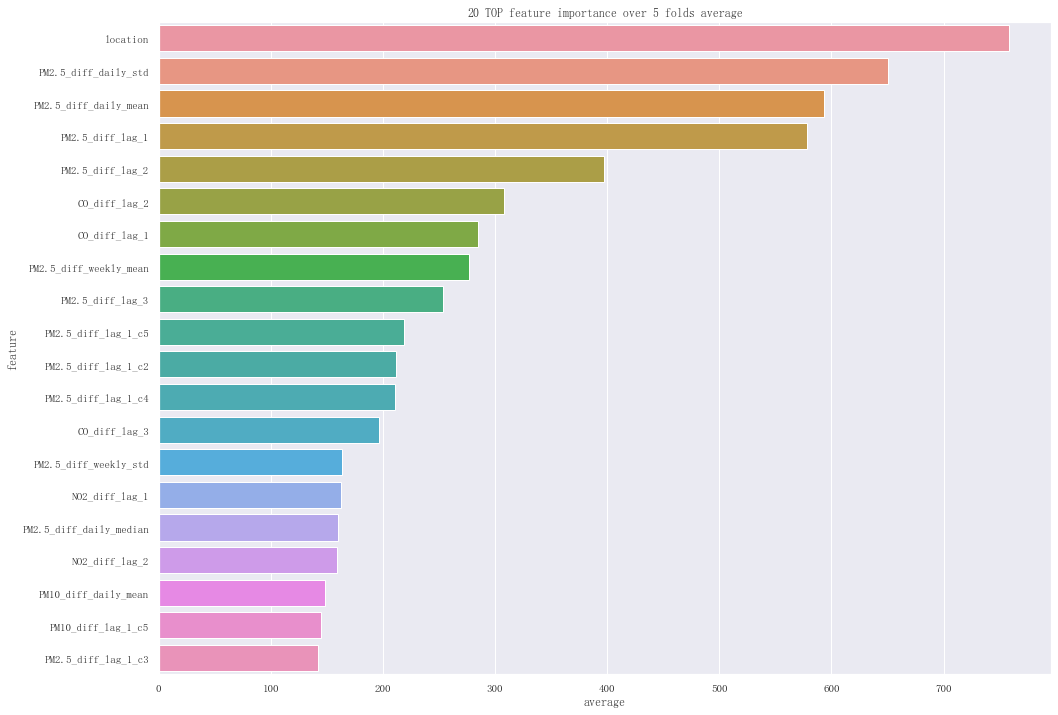

In [50]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature')
plt.title('20 TOP feature importance over {} folds average'.format(n_splits))

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'pytorch'
